In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import json
import requests

QUOTES_URL = 'https://iss.moex.com/iss/history/engines/stock/markets/shares/boards/TQBR/securities/{security}.json' \
                  '?from={start}&till={end}&iss.meta=off'

DIVIDENDS_URL = 'https://iss.moex.com/iss/securities/{security}/dividends.json?iss.meta=off'

def retrieve_quotes(security, start, end):
    url = QUOTES_URL.format(
    security = security,
    start = start,
    end = end)
    r = requests.get(url)
    data = pd.read_json(json.dumps(r.json()['history']), orient = 'split', typ = 'frame')
    data['TRADEDATE'] = data['TRADEDATE'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    return data

def retrieve_dividends(security):
    url = DIVIDENDS_URL.format(security = security)
    r = requests.get(url)
    data = pd.read_json(json.dumps(r.json()['dividends']), orient = 'split', typ = 'frame')
    data['registryclosedate'] = data['registryclosedate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    return data

def merge_quotes(security, start, end):
    dt_start = datetime.strptime(start, '%Y-%m-%d')
    dt_end = datetime.strptime(end, '%Y-%m-%d')
    quotes = retrieve_quotes(security, start, end)
    last = quotes['TRADEDATE'].to_list()[-1]
    while (dt_end - last).days > 5:
        dt_start = last + timedelta(days = 1)
        start = datetime.strftime(dt_start, '%Y-%m-%d')
        tmp = retrieve_quotes(security, start, end)
        quotes = pd.concat([quotes, tmp])
        last = quotes['TRADEDATE'].to_list()[-1]
    quotes.reset_index(inplace = True)
    quotes.drop(columns = ['index'], inplace = True)
    quotes.set_index('TRADEDATE', inplace = True)
    return quotes

def validate_dividends(divs, quotes):
    new_vals = []
    for i in range(len(divs)):
        date = divs.iloc[i]['registryclosedate']
        pre_div = quotes.loc[:date - timedelta(days = 2)].iloc[-1]['HIGH']
        post_div = quotes.loc[date - timedelta(days = 1):].iloc[0]['LOW']
        if (pre_div - post_div) < (divs.iloc[i]['value'] / 2):
            new_vals.append(0)
        else:
            new_vals.append(divs.iloc[i]['value'])
    divs['value'] = new_vals
    
def calculate_adjusted_prices(divs, quotes):
    price_mults = np.ones(len(quotes))
    for i in range(len(divs)):
        date = divs.iloc[i]['registryclosedate']
        close = quotes.loc[:date - timedelta(days = 2)].iloc[-1]['CLOSE']
        new_mult = (close - divs.iloc[i]['value']) / close
        price_mults *= np.where(quotes.index >= 
                           (divs.iloc[i]['registryclosedate'] - timedelta(days = 1)), 1, new_mult)
    quotes['ADJ_CLOSE'] = quotes['CLOSE'] * price_mults

In [2]:
divs = retrieve_dividends('GAZP')

In [3]:
data = merge_quotes('GAZP', '2014-01-01', '2023-08-10')

In [4]:
validate_dividends(divs, data)

In [5]:
calculate_adjusted_prices(divs, data)

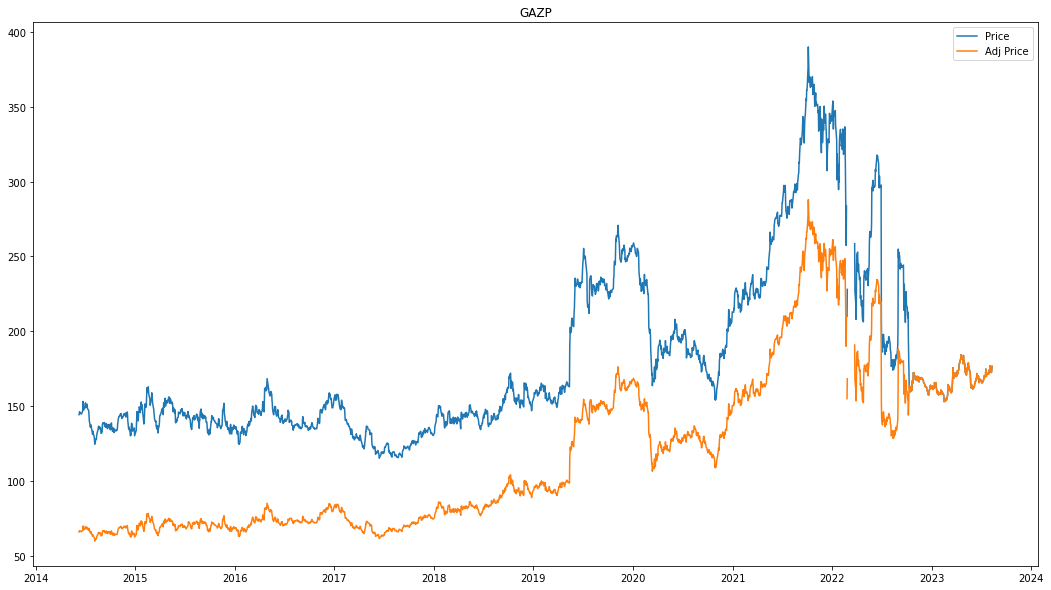

In [6]:
import matplotlib.pylab as plt

fig = plt.figure(figsize = (18, 10))

plt.title('GAZP')
plt.plot(data['CLOSE'], label = 'Price')
plt.plot(data['ADJ_CLOSE'], label = 'Adj Price')
plt.legend()

plt.show()